# Homework 5
## AMATH 585
### Shabab Ahmed 

#### Problem 5:

Consider the problem
$$
\frac{d}{dx}\left(\kappa(x) u'(x)\right) = f(x)
$$
on $0\leq x \leq 1$ with $\kappa(x) >0$ everywhere. 

(a) Determine the solution of this problem for the case of $f(x)=0$ and
a discontinuous $\kappa(x)$ given by


$$\kappa(x) =\Bigg\{{0.1 \ \text{if} \  x < 0.5, \ \ \
 1\ \text{if}\  x > 0.5}.
$$


with boundary conditions $u(0) = 0$ and $u(1) = 1$. The solution should be
continuous and piecewise linear with a discontinuity in slope at $x=0.5$
(Note this could model steady steady heat flow through a material that
conducts heat better on the right half than on the left.)


(b) Now suppose we discretize using the symmetric matrix $A$ of
(2.73) in the text.  Choose $m=19$ (odd, so there is a grid point exactly
at $x=0.5$, in which case the solution to the discrete system should
agree with the exact solution of the differential equation).

Write a computer code to solve this system using the SOR method for an
arbitrary value of $\omega$.  Note that setting $\omega = 1$ should just
reduce to the Gauss-Seidel method for comparison.  

Test this code and estimate the rate of convergence with $\omega = 1, \omega = 1.7$ and
with $\omega = 0.7$, by doing a least squares fit of the convergence
history as demonstrated in the notebook $\texttt{IterativeMethods.ipynb}$.

We have shown in the homework that the true solution is 

$$u(x) =\Bigg\{{\frac{10}{5.5}x \ \text{if} \  x < 0.5, \ \ \
 \frac{1}{5.5}(x+4.5)\ \text{if}\  x > 0.5}.
$$

In this step we write a computer code to solve this system using SOR. 

In [1]:
%matplotlib inline

In [2]:
from pylab import *

In [3]:
m = 19
h=1/m+1
f_fcn = lambda x: 0*x
utrue_fcn = lambda x: piecewise(x, [x < 0.5, x >= 0.5], [lambda x: (10/5.5)*x, lambda x: (x+4.5)/(5.5)])
kappa = lambda x: piecewise(x, [x < 0.5, x >= 0.5], [lambda x: 0*x+0.1, lambda x: 0*x+1])

To better illustrate the sequence of approximate solutions obtained as we iterate, we will use a widget to display a sequence of plots in a way that we can easily look through them. 

The function animate_figs defined below invokes an iteractive widget to loop over a set of matplotlib figures that have been generated in some loop and stored as a list called figs:

In [4]:
from ipywidgets import interact
import ipywidgets as widgets

def animate_figs(figs):
    show_frame = lambda frameno: display(figs[frameno])
    interact(show_frame, frameno=widgets.IntSlider(min=0,max=len(figs)-1, value=0))

Here's the update method for SOR. We can change `omega` to different values to see how this affects convergence.  It should converge as long as $0 < \omega < 2$ but even small changes in $\omega$ will give much poorer results than the optimal.  (And recall that $\omega = 1$ corresponds to Gauss-Seidel, so setting $\omega < 1$ would be *under-relaxed* and converge even slower than G-S.) This is exactly what we see in our case. We see best convergence with `omega` = 1.7 and worst convergence with `omega` = 0.7. This piece of code is taken from the \texttt{IterativeMethods} notebook but we have modified to allow for new discretized matrix when we have a variable coefficient problem. The discretization of $\frac{d}{dx}(\kappa u(x))$ becomes: 

$$
\frac{1}{h^2}[\kappa_{i+\frac{1}{2}}(U_{i+1}-U_{i}) - \kappa_{i-\frac{1}{2}}(U_i-U_{i-1})] -f(x_i)
$$

Therefore, we get: 

$$ 
U_{i} = \frac{1}{\kappa_{i+\frac{1}{2}}+\kappa_{i-\frac{1}{2}}}(\kappa_{i-\frac{1}{2}}U_{i-1} +\kappa_{i+\frac{1}{2}}U_{i+1} - h^2f(x_i))\times (\omega+(1-\omega)U_i)
$$

at each update. 

In [5]:
#omega = 0.7
#omega = 1
omega= 1.7
def update_u_SOR(U, F, h, kappa,x):
    """
    Input: Current iterate U^[k-1]
    Output: Next iterate U^[k]
    """

    m = len(U) - 2
    for i in range(1,m+1):
        x_imh_j = x[i] - h/2    #x_{i-1\2}
        kappa_imh_j = kappa(x_imh_j) # kappa_{i-1/2}
        x_iph_j = x[i] + h/2.         #x_{1+1/2}
        kappa_iph_j = kappa(x_iph_j) # kappa_{i+1/2} 
        U[i] = (1/(kappa_imh_j+kappa_iph_j))*(kappa_imh_j*U[i-1] + kappa_iph_j*U[i+1] - h**2 * F[i])*omega \
               + (1-omega)*U[i]
    return U

In [6]:
def solve_bvp(f_fcn, utrue_fcn, kappa, m, update_u, maxiter, kplot):

    alpha = utrue_fcn(0)
    beta = utrue_fcn(1)

    h = 1./(m+1)
    x = linspace(0,1,m+2)

    utrue = utrue_fcn(x)
    F = f_fcn(x)

    U0 = linspace(alpha, beta, m+2) # initial guess
    U = U0.copy() # current iterate

    max_error = abs(U-utrue).max()
    errors = [max_error]

    figs = []  # for the list of figures we generate
    
    for k in range(1,maxiter+1):     
        U = update_u(U, F, h, kappa,x)  # take one iteration
        
        max_error = abs(U-utrue).max()
        errors.append(max_error)

        if mod(k,kplot)==0 or k==maxiter:
            # every kplot iterations create a plot:
            fig = figure(figsize=(12,5))
            plot(x,U0,'r-o', label='initial guess')
            plot(x,utrue,'k-o', label='true solution')
            plot(x,U,'bo-', label= 'iteration k = %i' % k)
            legend()
            grid(True)
            xlim(0,1)
            ylim(0, 3)
            title('After %i iterations, max error = %.2e' \
                  % (k, max_error))
            figs.append(fig)
            close(fig)
            
    errors = array(errors)  # convert list to numpy array
    return errors, figs


In [7]:
errors_SOR, figs = solve_bvp(f_fcn, utrue_fcn, kappa, m=m, update_u=update_u_SOR, 
                             maxiter=100, kplot=5)
animate_figs(figs)

interactive(children=(IntSlider(value=0, description='frameno', max=19), Output()), _dom_classes=('widget-inte…

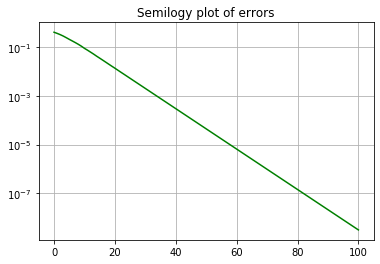

In [8]:
semilogy(errors_SOR, 'g', label='SOR');
title('Semilogy plot of errors')
grid(True)

Since we expect $\log(E(k)) \approx \log(C) + k\log(\rho)$ and the convergence looks so linear, we could fit a straight line through a couple points on these plots and easily estimate $\log(\rho)$.  

A more general approach, if the convergence is a bit ragged, would be to do a least squares fit of a linear function to more points (say $n$) from this convergence plot, setting up a linear system using $\log(E_i) = c_1 + c_2 k_i$ for $i=1,~2,~\ldots,~n$,

$$
\left[\begin{array}{cc}
1 & k_1\\
1 & k_2\\
\vdots & \vdots \\
1 & k_n
\end{array}\right]
\left[\begin{array}{c}
c_1\\
c_2
\end{array}\right]
=
\left[\begin{array}{c}
\log(E_1)\\
\log(E_2)\\
\vdots\\
\log(E_n)
\end{array}\right]
$$

and then solving this in the least squares sense for $[c_1,~c_2]$.  Then $\rho \approx \exp(c_2)$.  

Here we explicitly set up and solve this least square problem using [numpy.linalg.lstsq]

In [9]:
def convergence_rate(k_vals, errors):
    n = len(k_vals)
    assert len(errors) == n, 'k_vals and errors must have the same length'
    print('Estimating rate based on %i values' % n)
    B = vstack((ones(n),k_vals)).T
    logE = log(errors)
    
    # solve least square problem:
    c, residuals, rank, s = lstsq(B,logE,rcond=None)
    
    logC = c[0]
    logrho = c[1]
    C = exp(logC)
    rho = exp(logrho)
    print('Convergence approximately like  E(k) = %.3f * rho**k   with rho = %.8f' % (C,rho))

In [10]:

k_vals = arange(50, 100, dtype=int)
rho_SOR = convergence_rate(k_vals, errors_SOR[k_vals])



Estimating rate based on 50 values
Convergence approximately like  E(k) = 0.622 * rho**k   with rho = 0.82619976
